# 导入所需包

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

2.3.0


c:\Users\Susan_Jay\.conda\envs\deeplearning\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Susan_Jay\.conda\envs\deeplearning\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Susan_Jay\.conda\envs\deeplearning\lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_defau

# 导入数据集

In [3]:
train_labels = pd.read_csv('train_labels.csv')
train_sequences = pd.read_csv('train_sequences.csv')
test_sequences = pd.read_csv('test_sequences.csv')
valid_labels = pd.read_csv('validation_labels.csv')
valid_sequences = pd.read_csv('validation_sequences.csv')
submission = pd.read_csv('sample_submission.csv')

# 数据预处理

In [4]:
train_labels['target'] = train_labels['ID'].str.rsplit('_', n=1).str[0]
valid_labels['target'] = valid_labels['ID'].str.rsplit('_', n=1).str[0]

train = train_sequences.merge(train_labels, how='left', left_on='target_id', right_on='target')
validation = valid_sequences.merge(valid_labels, how='left', left_on='target_id', right_on='target')

train['temporal_cutoff'] = pd.to_datetime(train['temporal_cutoff']).astype('int64') 
test_sequences['temporal_cutoff'] = pd.to_datetime(test_sequences['temporal_cutoff']).astype('int64')
validation['temporal_cutoff'] = pd.to_datetime(validation['temporal_cutoff']).astype('int64')

In [5]:
submission['target'] = submission['ID'].str.rsplit('_', n=1).str[0]  # 提取目标RNA名称
test = test_sequences.merge(submission, how='left', left_on='target_id', right_on='target')

In [6]:
# 生成序列的长度
train['seq_length'] = train['sequence'].str.len()
test['seq_length'] = test['sequence'].str.len()
validation['seq_length'] = validation['sequence'].str.len()

# 特征补充

In [7]:
# --------------------------------------------------------------新加特征: 前两个碱基、后两个碱基--------------------------------------------------------------
# 原理：对于局部的特定结构可能会有相似的位置关系，比如"ACC"这三个连着的碱基，
# 它们可能都是有相似的相对关系，中间的C在上面旁边的AC在下面。
def prev_and_next(df):
    # 定义一个字典，指定要添加的上下文特征及其偏移量: 正值表示向前移动（获取前面的残基）, 负值表示向后移动（获取后面的残基）
    shifts = {
        'prev_res': 1,       # 前一个残基
        'next_res': -1,      # 后一个残基
        'prev_two_res': 2,   # 前两个残基
        'next_two_res': -2   # 后两个残基
    }

    # 生成前后残基，按RNA分组再shift
    for col_name, shift_value in shifts.items():
        df[col_name] = df.groupby('target_id')['resname'].shift(shift_value)

    for col in shifts.keys():
        df[col] = df[col].fillna('NA')  # 或使用其他合适的填充值
    
    return df

# --------------------------------------------------------------核苷酸组成特征（碱基组成特征）--------------------------------------------------------------
def add_nucleotide_composition(df):
    # 计算序列中GC含量(G+C碱基占总长度的比例)
    df['GC_content'] = df['sequence'].apply(lambda x: (x.count('G') + x.count('C'))/len(x))
    # 计算序列中AU含量(A+U碱基占总长度的比例)
    df['AU_content'] = df['sequence'].apply(lambda x: (x.count('A') + x.count('U'))/len(x))
    # 以及单独计算G、A、C、U的比例
    df['G_content'] = df['sequence'].apply(lambda x: x.count('G')/len(x))
    df['A_content'] = df['sequence'].apply(lambda x: x.count('A')/len(x))
    df['C_content'] = df['sequence'].apply(lambda x: x.count('C')/len(x))
    df['U_content'] = df['sequence'].apply(lambda x: x.count('U')/len(x))
    return df

# --------------------------------------------------------------局部结构复杂度--------------------------------------------------------------
def add_local_complexity(df):
    def calc_local_complexity(seq, window=5):
        # seq: RNA序列字符串
        # window: 窗口大小参数，默认为5（表示考虑当前位置周围共11个碱基）
        result = []   # 创建一个空列表，用于存储序列中每个位置的局部复杂度值
        for i in range(len(seq)):
            start = max(0, i-window)   # 计算窗口的起始位置，确保不越界
            end = min(len(seq), i+window+1)   # 计算窗口的结束位置，确保不越界

            # 提取子序列：获取局部窗口范围内的RNA子序列
            # 结果：得到以当前位置为中心的局部序列片段
            local_seq = seq[start:end]

            # 计算局部GC含量
            # 原理：GC含量是RNA结构稳定性的重要指标，GC碱基对形成3个氢键，比AU碱基对(2个氢键)更稳定
            # 生物学意义：GC含量高的区域通常形成更稳定的结构
            local_gc = (local_seq.count('G') + local_seq.count('C'))/len(local_seq)
            result.append(local_gc)
        return np.mean(result)   # 返回局部复杂度的平均值
    
    df['local_complexity'] = df['sequence'].apply(calc_local_complexity)
    return df

# --------------------------------------------------------------堆叠能量特征--------------------------------------------------------------
def add_stacking_energy(df):   # 定义堆叠能量参数 (kcal/mol)
    # 字典定义：创建包含所有16种可能二核苷酸堆叠能量值的字典
    # 数据来源：这些参数基于实验测定的热力学数据
    # 单位：千卡/摩尔(kcal/mol)，负值表示稳定相互作用
    # 物理意义：数值越小（越负）表示堆叠作用越稳定，如CC(-3.36)比AA(-0.93)更稳定
    stacking_energy = {
        'AA': -0.93, 'AC': -2.24, 'AG': -1.30, 'AU': -1.10,
        'CA': -2.11, 'CC': -3.36, 'CG': -2.36, 'CU': -2.08,
        'GA': -1.41, 'GC': -2.44, 'GG': -1.53, 'GU': -1.80,
        'UA': -0.90, 'UC': -1.70, 'UG': -1.80, 'UU': -0.80
    }
    
    def calc_avg_stacking(seq):
        if len(seq) <= 1:
            return 0
        energy = 0   # 累计总堆叠能量，初始为0
        pairs = 0    # 计数有效的二核苷酸对，初始为0
        
        # 遍历序列中的每个二核苷酸对（长度为2的子序列）
        for i in range(len(seq)-1):
            dinuc = seq[i:i+2]
            if dinuc in stacking_energy:
                energy += stacking_energy[dinuc]
                pairs += 1
        # 计算平均堆叠能量：将总能量除以有效的二核苷酸对数
        return energy/pairs if pairs > 0 else 0
    
    df['avg_stacking_energy'] = df['sequence'].apply(calc_avg_stacking)
    return df

# --------------------------------------------------------------结构模块特征--------------------------------------------------------------
def add_structural_motifs(df):
    # 常见的RNA结构模块模式:

    # tetraloop_GNRA: G + 任意核苷酸 + 嘌呤(A或G) + A
    # 功能：极其稳定的发夹环结构，常促进长程相互作用
    # 生物学意义：在核糖体RNA中高度保守，影响RNA整体折叠

    # tetraloop_UNCG: U + 任意核苷酸 + C + G
    # 功能：热力学上非常稳定的四核苷酸环
    # 生物学意义：能够稳定相邻的RNA结构元素

    # kink_turn: GA + 两个任意核苷酸 + A + 任意核苷酸 + A
    # 功能：导致RNA主链形成典型的"扭折"结构
    # 生物学意义：常见于复杂RNA结构的转角处，造成约120°的转弯

    # C_loop: CC + 任意两核苷酸(NN) + 5-7个任意核苷酸 + GG
    # 功能：形成特殊的RNA内部环状结构
    # 生物学意义：常与蛋白结合，参与RNA-蛋白互作
    motifs = {
        'tetraloop_GNRA': r'G[AGUC][AG]A',   
        'tetraloop_UNCG': r'U[AGUC]CG',       
        'kink_turn': r'GA[AGUC]{2}A[AGUC]A',  
        'C_loop': r'CC[AGUC]{2}[AGUC]{5,7}GG' # 可简化为CC[AGUC]{7,9}GG, 但保留结构语义
    }
    
    import re
    for motif_name, pattern in motifs.items():
        # 模式匹配：
        # re.search(pattern, x)：在序列x中搜索模式pattern
        # 返回值：找到匹配返回1，未找到返回0
        df[f'has_{motif_name}'] = df['sequence'].apply(
            lambda x: 1 if re.search(pattern, x) else 0)
    
    return df

In [8]:
# 应用特征工程
for df in [train, validation, test]:
    df = prev_and_next(df)  # 添加上下文特征
    df = add_nucleotide_composition(df)  # 添加核苷酸组成特征
    df = add_local_complexity(df)  # 添加局部结构复杂度特征
    df = add_stacking_energy(df)   # 添加堆叠能量特征
    df = add_structural_motifs(df)  # 添加结构模块特征

# 选择有效特征

In [9]:
categorical_columns = ['target_id','resname','seq_length','prev_res','next_res','prev_two_res','next_two_res','GC_content', 'AU_content', 
                       'G_content', 'A_content','C_content', 'U_content', 'local_complexity', 'avg_stacking_energy',
                       'has_tetraloop_GNRA', 'has_tetraloop_UNCG', 'has_kink_turn','has_C_loop']

labels_columns = ['x_1', 'y_1', 'z_1']  # 目标列

In [10]:
# 删掉不需要的列(文字描述的暂时没有办法有效处理, 先删掉, 后面再说)
def keep_only_categorical_columns(df, columns_to_keep):
    """
    删除数据框中不在指定列表的所有列
    
    参数:
    df (DataFrame): 需要处理的pandas数据框
    columns_to_keep (list): 要保留的列名列表
    
    返回:
    DataFrame: 只包含指定列的数据框
    """
    # 找出df中存在的列中包含在columns_to_keep中的列
    # 这样处理可以避免尝试访问不存在的列
    existing_columns = [col for col in columns_to_keep if col in df.columns]
    
    # 只保留这些列
    return df[existing_columns]

# 应用到所有三个数据集
train_labels = keep_only_categorical_columns(train, labels_columns)
valid_labels = keep_only_categorical_columns(validation, labels_columns)

Train = keep_only_categorical_columns(train, categorical_columns)
Test = keep_only_categorical_columns(test, categorical_columns)
Validation = keep_only_categorical_columns(validation, categorical_columns)

# 打印处理后的形状，验证结果
print(f"处理后的数据集形状:")
print(f"Train: {Train.shape}")
print(f"Test: {Test.shape}")
print(f"Validation: {Validation.shape}")

# 查看保留的列名
print("\n保留的列:")
print(Train.columns.tolist())

处理后的数据集形状:
Train: (137095, 19)
Test: (2515, 19)
Validation: (2515, 19)

保留的列:
['target_id', 'resname', 'seq_length', 'prev_res', 'next_res', 'prev_two_res', 'next_two_res', 'GC_content', 'AU_content', 'G_content', 'A_content', 'C_content', 'U_content', 'local_complexity', 'avg_stacking_energy', 'has_tetraloop_GNRA', 'has_tetraloop_UNCG', 'has_kink_turn', 'has_C_loop']


In [11]:
train_labels.head(5)  # 查看处理后的训练标签数据集的前5行

,x_1,y_1,z_1
0,13.760,-25.974001,0.102
1,9.310,-29.638000,2.669
2,5.529,-27.813000,5.878
3,2.678,-24.900999,9.793
4,1.827,-20.136000,11.793


In [12]:
train_labels['x_1'][0]

13.760000228881836

In [13]:
Train.head(5)

,target_id,resname,seq_length,prev_res,next_res,prev_two_res,next_two_res,GC_content,AU_content,G_content,A_content,C_content,U_content,local_complexity,avg_stacking_energy,has_tetraloop_GNRA,has_tetraloop_UNCG,has_kink_turn,has_C_loop
0,1SCL_A,G,29,NA,G,NA,G,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.648222,-1.941071,1,1,0,0
1,1SCL_A,G,29,G,G,NA,U,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.648222,-1.941071,1,1,0,0
2,1SCL_A,G,29,G,U,G,G,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.648222,-1.941071,1,1,0,0
3,1SCL_A,U,29,G,G,G,C,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.648222,-1.941071,1,1,0,0
4,1SCL_A,G,29,U,C,G,U,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.648222,-1.941071,1,1,0,0


# 合并训练集和测试集

In [14]:
all_features = pd.concat((Train.iloc[:, :], Validation.iloc[:, :], Test.iloc[:, :]))
# 这里的iloc[:, :]表示选择所有行和所有列
all_features.shape

(142125, 19)

# 数据编码-数据进阶处理

In [15]:
n_train = Train.shape[0]   # 训练集的行数
n_test = Test.shape[0]     # 测试集的行数
n_valid = Validation.shape[0]   # 验证集的行数

In [16]:
train_ids_and_seqlength = Train[['target_id', 'seq_length']].copy()
valid_ids_and_seqlength = Validation[['target_id', 'seq_length']].copy()
test_ids_and_seqlength = Test[['target_id', 'seq_length']].copy()
print(train_ids_and_seqlength.head(5))  # 查看训练集的target_id和seq_length的前5行
print(train_ids_and_seqlength.shape)  # 查看训练集的target_id和seq_length的形状
print(train_ids_and_seqlength['target_id'][29], train_ids_and_seqlength['seq_length'][29])  # 查看训练集的唯一target_id数量

  target_id  seq_length
0    1SCL_A          29
1    1SCL_A          29
2    1SCL_A          29
3    1SCL_A          29
4    1SCL_A          29
(137095, 2)
1RNK_A 34


In [17]:
# all_features.dtypes：获取每一列的数据类型
# all_features.dtypes != 'object'：创建一个布尔掩码，标记非对象(非字符串)类型列
# [...].index：获取符合条件的列名索引
# 目的：识别数据集中的所有数值类型特征（区别于分类特征）
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# .apply()：对每列应用同一函数
# lambda x: (x - x.mean()) / (x.std())：标准化公式，转换每列为均值0、标准差1的分布
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [18]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
# 主要作用：将分类特征(文本、枚举类型)转换为数值特征矩阵
# 处理对象：数据框中所有非数值型(object类型)的列
# 找出除target_id外需要编码的列（此处我不希望target_id成为训练特征，只是用来标识数据）
cols_to_encode = [col for col in all_features.columns if col != 'target_id' and all_features[col].dtype == 'object']

# 只对这些列进行编码
all_features = pd.get_dummies(all_features, columns=cols_to_encode, dummy_na=True)

all_features.shape

(142125, 51)

In [19]:
all_features.head(5)  # 查看处理后的数据集的前5行

,target_id,seq_length,GC_content,AU_content,G_content,A_content,C_content,U_content,local_complexity,avg_stacking_energy,...,prev_two_res_U,prev_two_res_X,prev_two_res_nan,next_two_res_-,next_two_res_A,next_two_res_C,next_two_res_G,next_two_res_NA,next_two_res_U,next_two_res_nan
0,1SCL_A,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,1.127604,-1.349871,...,False,False,False,False,False,False,True,False,False,False
1,1SCL_A,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,1.127604,-1.349871,...,False,False,False,False,False,False,False,False,True,False
2,1SCL_A,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,1.127604,-1.349871,...,False,False,False,False,False,False,True,False,False,False
3,1SCL_A,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,1.127604,-1.349871,...,False,False,False,False,False,True,False,False,False,False
4,1SCL_A,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,1.127604,-1.349871,...,False,False,False,False,False,False,False,False,True,False


In [20]:
# 先保存target_id列
target_ids = all_features['target_id'].copy()

# 移除target_id并转换其他列为float32类型
all_features = all_features.drop('target_id', axis=1).astype('float32')

# 将target_id添加回来(不转换类型)
all_features['target_id'] = target_ids

print(all_features.shape)  # 打印处理后的数据集形状

# 特征和标签分离
# 这里的target_id是一个标识符，不是特征，所以我们不需要它
features_cols = [col for col in all_features.columns if col != 'target_id']
train_features = torch.tensor(all_features[features_cols][:n_train].values, dtype=torch.float)
validation_features = torch.tensor(all_features[features_cols][n_train:n_train+n_valid].values, dtype=torch.float)
test_features = torch.tensor(all_features[features_cols][n_train+n_valid:].values, dtype=torch.float)

train_labels = torch.tensor(train_labels.values, dtype=torch.float).view(-1, 3)  # 转换为3列
valid_labels = torch.tensor(valid_labels.values, dtype=torch.float).view(-1, 3)  # 转换为3列

(142125, 51)


In [21]:
train_labels.shape, valid_labels.shape, train_features.shape, validation_features.shape, test_features.shape

(torch.Size([137095, 3]),
 torch.Size([2515, 3]),
 torch.Size([137095, 50]),
 torch.Size([2515, 50]),
 torch.Size([2515, 50]))

In [22]:
from torch.utils.data import TensorDataset, DataLoader
# 下面用于测试数据集的创建和加载，查看数据集格式是否正确

# # TensorDataset：将特征和标签组合成一个数据集对象，便于后续的批处理
# train_dataset = TensorDataset(train_features, Train_labels)  # 创建训练集数据集对象
# valid_dataset = TensorDataset(validation_features, Valid_labels)  # 创建验证集数据集对象
# test_dataset = TensorDataset(test_features)  # 创建测试集数据集对象（没有标签）

# # 创建DataLoader
# batch_size = 32  # 可以根据需要调整

# train_iter = DataLoader(
#     train_dataset, 
#     batch_size=batch_size, 
#     shuffle=True,  # 训练时打乱数据
#     num_workers=0  # Windows下建议使用0
# )

# valid_iter = DataLoader(
#     valid_dataset, 
#     batch_size=batch_size,
#     shuffle=False  # 验证不需要打乱
# )

# test_iter = DataLoader(
#     test_dataset, 
#     batch_size=batch_size,
#     shuffle=False  # 测试不需要打乱
# )

# # 验证数据集格式是否正确
# for X, y in train_iter:
#     print(f"特征批次形状: {X.shape}")  # 应该是[批次大小, 49]
#     print(f"标签批次形状: {y.shape}")  # 应该是[批次大小, 3]
#     print(f"第一个样本特征: {X[0][:5]}...")  # 展示部分特征
#     print(f"第一个样本标签: {y[0]}")  # 展示标签(x,y,z坐标)
#     break  # 只查看第一批次

In [23]:
# 多维回归的损失函数
def rmse_3d_loss(pred, target):
    """计算3D坐标的RMSE损失"""
    # 计算每个样本的欧氏距离平方
    squared_diff = torch.sum((pred - target)**2, dim=1)
    # 取平方根得到欧氏距离
    distances = torch.sqrt(squared_diff)
    # 返回平均距离
    return torch.mean(distances)

# 使用MSE损失的替代方案
# loss_fn = nn.MSELoss()  # 会自动处理多维输出


In [24]:
num_inputs = train_features.shape[1]  # 输入特征的维度
num_outputs = train_labels.shape[1]  # 输出目标的维度

# 创建一个带有丢弃法正则化的多层神经网络
def get_net(num_inputs, num_outputs=3):
    net = nn.Sequential(
            # d2l.FlattenLayer(): 自定义层，将输入的多维张量展平为二维
            # 例如：将 (batch_size, 1, 28, 28) 的图像转换为 (batch_size, 784)
            d2l.FlattenLayer(),   
            nn.Linear(num_inputs, 256),  
            nn.ReLU(),   # 激活函数，引入非线性变换
            nn.Dropout(0.2),   # 第一个丢弃层，随机断开第一隐藏层的部分连接
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_outputs)   # 输出维度为num_outputs = 10，对应Fashion-MNIST的10个类别
            )

    for param in net.parameters():
        # 使用正态分布初始化网络参数,下划线表示这是一个原地操作，直接修改参数
        nn.init.normal_(param, mean=0, std=0.01)

    return net   

# num_inputs, num_hiddens1, num_hiddens2, num_outputs   # 打印网络参数

In [25]:
net = get_net(num_inputs)  # 创建模型实例

# 执行前向传播并获取输出
dummy_input = torch.randn(train_features.shape[0], num_inputs)
with torch.no_grad():
    output = net(dummy_input)

print(output.shape)   # 测试网络的输出形状，应该是[批次大小, 3]，即3D坐标
print(output.shape[0])  # 打印第一个维度大小(批次大小)
print(output[0])  # 打印第一个样本的输出坐标
print(output[0][1])  # 打印第一个样本的第一个坐标值

torch.Size([137095, 3])
137095
tensor([0.0092, 0.0031, 0.0077])
tensor(0.0031)


# TM-score

In [26]:
def evaluation_function(ids_and_seqlength, pred, target):   
    # ids为上文train_ids_and_seqlength, validation_ids_and_seqlength, test_ids_and_seqlength之一
    # pred为模型预测的坐标net的输出
    # target为真实的坐标Train_labels, Valid_labels, Test_labels之一
    '''计算当前rna目标序列d0值'''
    def calculate_d0(seq_len):
        if seq_len > 30:
            # 如果序列长度大于30，使用公式计算：0.6*(seq_len-0.5)**0.5-2.5
            # 这是一个平方根函数，随着序列变长，d0值会增加但增速会减慢
            return 0.6*(seq_len-0.5)**0.5-2.5
        else:
            # 当序列长度≤30时，根据不同长度范围返回固定值：
            if seq_len < 12:
                return 0.3
            if seq_len < 16:
                return 0.4
            if seq_len < 20:
                return 0.5
            if seq_len < 24:
                return 0.6
            else:   
                return 0.7
    
    '''计算当前rna目标序列di值'''
    def calculate_dis(x1, y1, z1, x2, y2, z2):
        return ((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)**0.5
    
    '''calculate_tm_score函数计算预测RNA结构与目标结构之间的TM-score(Template Modeling score)'''
    def calculate_tm_score(ids_and_seqlength, pred, target):
        tm_score = []   # 初始化一个空列表tm_score存储每个RNA序列的TM-score
        cur_id = ''     # 初始化cur_id为空字符串，用于跟踪当前处理的RNA序列ID
        for i in range(pred.shape[0]):  # 遍历每一行（每个残基位置），此处的i是行索引
            # 如果遇到新序列就把上一个序列tm-score存起来，并重置其他记录
            if ids_and_seqlength['target_id'][i] != cur_id:   # 当遇到新序列时（当前行的target_id与之前不同）：
                if cur_id != '':
                    # 如果不是第一个序列（cur_id不为空），将上一个序列的累计得分除以序列长度，得到TM-score并保存
                    tm_score.append(cur_id_score/seq_len)
                seq_len = ids_and_seqlength['seq_length'][i]     # 获取当前序列的长度
                d0=calculate_d0(seq_len)            # 根据序列长度计算d0值（使用上一个函数中的calculate_d0）
                # 计算当前行（残基位置）的得分：1/(1+(距离²/d0²))
                cur_id_score = (1/(1+(calculate_dis(pred[i][0],pred[i][1],pred[i][2],target[i][0],target[i][1],target[i][2]))**2/d0**2))
                cur_id = ids_and_seqlength['target_id'][i]       # 更新当前处理的序列ID
                
            # 特殊处理最后一个样本，取所有tm-score均值作为输出
            # 如果是数据集的最后一行：添加最后一个序列的得分，然后返回所有序列TM-score的平均值
            # 否则：累加当前残基位置的得分
            else :
                if i == pred.shape[0]-1:
                    tm_score.append(cur_id_score/seq_len)
                    return np.mean(tm_score)
                else:
                    cur_id_score += (1/(1+(calculate_dis(pred[i][0],pred[i][1],pred[i][2],target[i][0],target[i][1],target[i][2]))**2/d0**2))
    
    with torch.no_grad():
        # 作用: 告诉PyTorch不要计算或存储梯度, 原因: 这是一个评估函数，不需要梯度来更新模型参数
        return calculate_tm_score(ids_and_seqlength, pred, target)  # 调用calculate_tm_score函数计算TM-score

# 模型训练

下面的训练函数使用了Adam优化算法, 相对之前使用的小批量随机梯度下降, 它对学习率相对不那么敏感

In [27]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size, train_ids_and_seqlength):
    train_ls = []  # 用于存储每个epoch的TM-score
    train_dataset = TensorDataset(train_features, train_labels)  # 创建训练集数据集对象
    train_iter = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,  # 训练时打乱数据
        num_workers=0  # Windows下建议使用0
    )
    
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = rmse_3d_loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        
        # 每个epoch结束后计算训练集的TM-score
        with torch.no_grad():
            # net.eval()：设置模型为评估模式，禁用dropout等训练时特性
            net.eval()
            output = net(train_features.float())
            train_ls.append(evaluation_function(train_ids_and_seqlength, output, train_labels))

    return train_ls

# K折交叉验证（waiting for coding）
在K折交叉验证中我们训练K次并返回训练和验证的平均误差

# 预测并在kaggle提交结果
下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式

In [28]:
import matplotlib.pyplot as plt

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size, train_ids_and_seqlength):
    net = get_net(train_features.shape[1])   # 以特征数量作为输入维度初始化神经网络模型
    train_ls = train(net, train_features, train_labels, None, None,   # None, None表示不使用验证集
                        num_epochs, lr, weight_decay, batch_size, train_ids_and_seqlength) 
           
    # 训练完成后，绘制TM-score随训练轮数的变化曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_ls, marker='o', linestyle='-')
    plt.xlabel('epochs')
    plt.ylabel('TM-score')
    plt.title('Training Metrics')
    plt.grid(True)
    plt.show()
    
    print('train rmse %f' % train_ls[-1])   # 打印最终训练误差

    # 对测试集进行预测
    # .detach()分离梯度追踪
    # .numpy()转换为NumPy数组便于后续处理
    preds = net(test_features).detach().numpy() 

    # 将预测结果转换为DataFrame格式，列名为['x_1', 'y_1', 'z_1']
    preds_df = pd.DataFrame(preds, columns=['x_1', 'y_1', 'z_1'])

    for i in range(2, 6):
        preds_df[f'x_{i}'] = preds_df['x_1']
        preds_df[f'y_{i}'] = preds_df['y_1']
        preds_df[f'z_{i}'] = preds_df['z_1']
    
    # 将预测结果添加到测试数据中
    submission[['x_1','y_1','z_1','x_2','y_2','z_2','x_3','y_3','z_3','x_4','y_4','z_4','x_5','y_5','z_5']] = preds_df[['x_1','y_1','z_1','x_2','y_2','z_2','x_3','y_3','z_3','x_4','y_4','z_4','x_5','y_5','z_5']] 

    submission.to_csv('submission.csv', index=False)

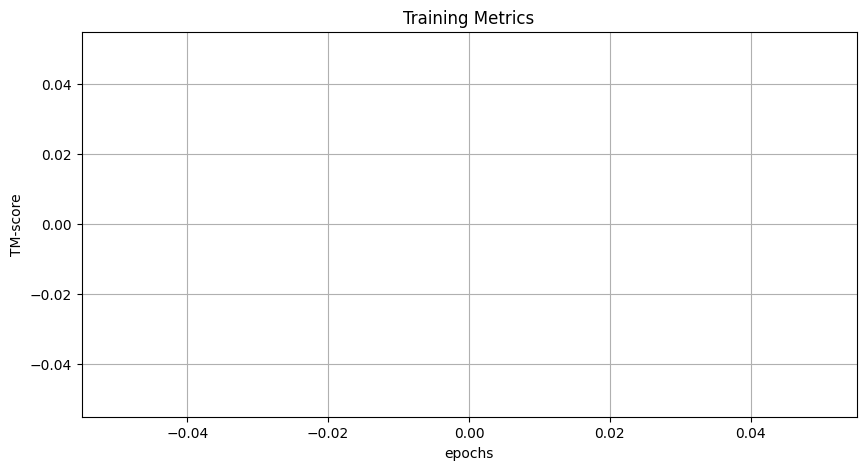

train rmse nan


In [29]:
num_epochs = 10  # 训练轮数
lr = 0.001  # 学习率
weight_decay = 0.01  # L2正则化系数
batch_size = 32  # 小批量大小
train_and_pred(train_features, test_features, train_labels, None, num_epochs, lr, weight_decay, batch_size, train_ids_and_seqlength)